# Prevalence of Personal Attacks

In this notebook, we do some basic investigation into the frequency of personal attacks on Wikipedia. We will attempt to provide some insight into the following questions:

- What fraction of comments are personal attacks?

- What fraction of users have made a personal attack?

- What fraction of users have been attacked on their user page?

- Are there any temporal trends in the frequency of attacks?


We have 2 separate types of data at our disposal. First, we have a random sample of roughly 100k human-labeled comments. Each comment was labeled by 10 separate people as to whether the comment is a personal attack. We can average these labels to get a single score. Second, we have the full history of comments with attack probabilities generated by a machine learning model. The machine learning model is imperfect. In particular, it is more conservative than human annotators about making "extreme" predictions. In particular, it is less likely to give non-attacks a score of 0 and also less likely to give attacks a score greater than 0.5, compared to humans (for more details, see the "Model Checking" notebook). For all questions above apart from the first, we will need to use the model scores.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from load_utils import *
from analysis_utils import compare_groups

In [2]:
d = load_diffs()
df_events, df_blocked_user_text = load_block_events_and_users()

### Q: What fraction of comments are personal attacks?

#### Methodology 1:
Compute fraction of comments predicted to be attacks for different classification thresholds. We can rely on just the human labeled data for this. However, we can also see what results we would get if we used the model predictions.

In [3]:
def prevalence_m1(d, sample, score, ts = np.arange(0.5, 0.91, 0.1)):

    d_a = pd.concat([pd.DataFrame({'threshold': t, 'attack': d[sample].query("ns=='article'")[score] >= t }) for t in ts], axis = 0)
    d_a['condition'] = 'article talk'

    d_u = pd.concat([pd.DataFrame({'threshold': t, 'attack': d[sample].query("ns=='user'")[score] >= t }) for t in ts], axis = 0) 
    d_u['condition'] = 'user talk'

    df = pd.concat([d_u, d_a])
    df['attack'] = df['attack'] * 100
    sns.pointplot(x="threshold", y="attack", hue="condition", data=df)
    plt.ylabel('percent of comments that are attacks')
    plt.ylim(-0.1, plt.ylim()[1])
    plt.savefig('../../paper/figs/threshold_prevalence_%s_%s' % (sample, score))


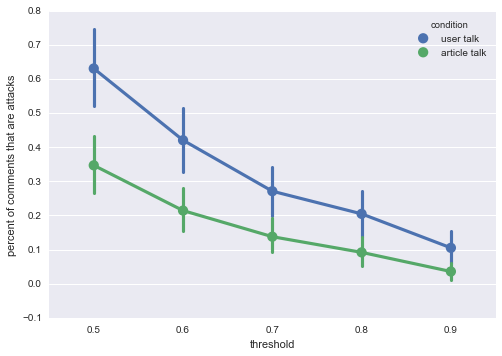

In [4]:
# human annotations
prevalence_m1(d, 'annotated', 'recipient_score')

A higher proportion of user talk comments are attacks. At a conservative threshold of 0.8, 1:400 user talk comments is an attack.

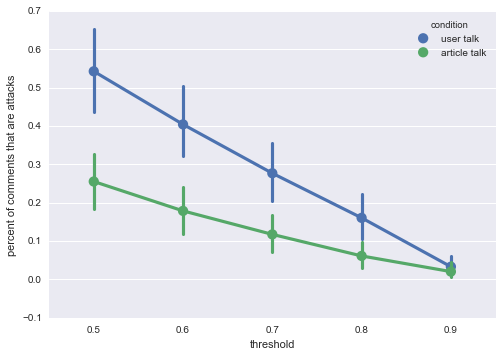

In [5]:
# model predictions on human annotated data
prevalence_m1(d, 'annotated', 'pred_recipient_score')

This is the same plot as above, except that we used the model scores instead of the mean human scores. The model gives fewer comments a score above 0.5. Hence, it suggests that a smaller proportion of comments is personal attacks. This is just for comparison. We can simply use the human scores to answer this question.

In [6]:
#prevalence_m1(d, 'sample', 'pred_recipient_score')

#### Methodology 2

A potential downside of measuring personal attacks as we did above is that, when we pick a threshold, we don't count any of the attacking comments with a score below the threshold. If we interpret the score as the probability that a human would consider the comment an attack, then we can use the scores to compute the expected fraction of attacks in a corpus. To get a measure of uncertainty, we can use the scores as probabilities in a simulation as follows: for each comment, label it as a personal attack with the probability assigned by the model/annotators. Count the fraction of comments labeled as personal attacks. Repeat to get a distribution and take 95% interval.

In [7]:
def prevalence_m2(d, sample, score, n = 100):
    def compute_ci(a, n = 10):
        m = a.shape[0]
        v = a.values.reshape((m,1))
        fs = np.sum(np.random.rand(m, n) < v, axis = 0) / m
        print("Percent of comments labeled as attacks: (%.3f, %.3f)" % ( 100*np.percentile(fs, 2.5), 100*np.percentile(fs, 97.5)))
    
    print('\nUser:')
    compute_ci(d[sample].query("ns=='user'")[score])
    print('Article:')
    compute_ci(d[sample].query("ns=='article'")[score])

In [8]:
# human annotations
prevalence_m2(d, 'annotated', 'recipient_score')


User:
Percent of comments labeled as attacks: (2.180, 2.456)
Article:
Percent of comments labeled as attacks: (1.337, 1.542)


This method gives that roughly 2.3% of user talk comments are personal attacks. I would consider this method less reliable than the above, since here we are relying on the fact that each annotator is high quality. Just having one trigger happy annotator for each comment already gives an expected attack fraction of 10%.

In [10]:
# model predictions on annotated data
prevalence_m2(d, 'annotated', 'pred_recipient_score')


User:
Percent of comments labeled as attacks: (3.956, 4.273)
Article:
Percent of comments labeled as attacks: (2.374, 2.647)


The model over-predicts relative to the annotators for method M2, since the model's score distribution is skewed right in the [0, 0.2] interval and that is where most of the data is. Again, we don't need the model scores to answer this question, I am just including it for comparison.

In [11]:
#prevalence_m2(d, 'sample', 'pred_recipient_score')

### Q: What fraction of users have made a personal attack?

#### Methodology 1:
Take unsampled data from 2015. Compute fraction of people who authored one comment above the threshold for different thresholds. Note: this requires using the model scores.

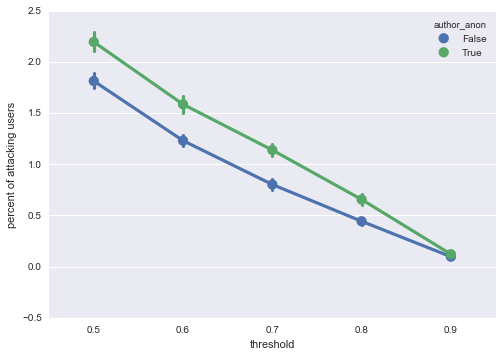

In [12]:
ts = np.arange(0.5, 0.91, 0.1)
dfs = []

for t in ts:
    
    dfs.append (\
                d['2015'].assign(attack= lambda x: 100 * (x.pred_recipient_score > t))\
                .groupby(['user_text', 'author_anon'], as_index = False)['attack'].max()\
                .assign(threshold = t)
                )
sns.pointplot(x='threshold', y = 'attack', hue = 'author_anon', data = pd.concat(dfs))
plt.ylabel('percent of attacking users')

- 1.6% of registered users have written at least one comment with a score above 0.5
- 0.5% of registered users have written at least one comment with a score above 0.8. 

#### Methodology 2:
Take unsampled data. For each comment, let it be an attack with probability equal to the model prediction. Count the number of users that have made at least 1 attack. Repeat.

In [15]:
def simulate_num_attacks(df, group_col = 'user_text'):
    n = df.assign( uniform = np.random.rand(df.shape[0], 1))\
        .assign(is_attack = lambda x: (x.pred_recipient_score >= x.uniform).astype(int))\
        .groupby(group_col)['is_attack']\
        .max()\
        .sum()
    return n

In [16]:
n_attacks = [simulate_num_attacks(d['2015']) for i in range(100)]        
100 * (np.percentile(n_attacks, [2.5, 97.5]) / len(d['2015'].user_text.unique()))  

array([ 10.47775131,  10.68694224])

In [17]:
# ignore anon users
d_temp = d['2015'].query('not author_anon and not recipient_anon')
n_attacks = [simulate_num_attacks(d_temp) for i in range(100)]        
100 * (np.percentile(n_attacks, [2.5, 97.5]) / len(d_temp.user_text.unique())) 

array([ 12.53118927,  12.77615624])

These results are inflated, due to model's right skew. This means that users with a lot of comments are very likely to be assigned at least one attacking comment in the simulation. I would not recommend using this method.

### Q: What fraction of users have been attacked on their user page?

#### Methodology:
Take unsampled data from 2015. Compute fraction of people who recieved one comment above the threshold for different thresholds.

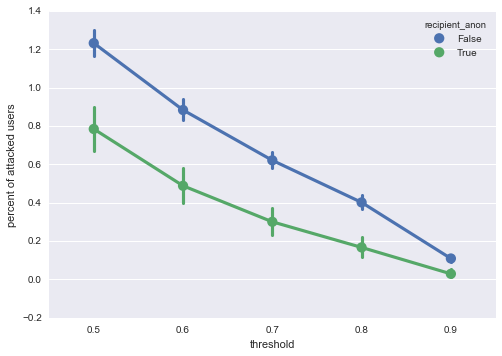

In [18]:
dfs = []

for t in ts:
    
    dfs.append (\
                d['2015'].query("not own_page and ns=='user'")\
                .assign(attack = lambda x: 100 * (x.pred_recipient_score >= t))\
                .groupby(['page_title', 'recipient_anon'], as_index = False)['attack'].max()\
                .assign(threshold = t)
                )
sns.pointplot(x='threshold', y = 'attack', hue = 'recipient_anon', data = pd.concat(dfs))
plt.ylabel('percent of attacked users')

#### Methodology 2:
Take unsampled data. For each comment, let it be an attack with probability equal to the model prediction. Count the number of users that have received at least 1 attack. Repeat.

In [19]:
n_attacks = [simulate_num_attacks(d['2015'].query("ns=='user'"), group_col = 'page_title') for i in range(10)]        
100 * (np.percentile(n_attacks, [2.5, 97.5]) / len(d['2015'].page_title.unique()))

array([ 3.90382998,  3.95989384])

In [20]:
# ignore anon users
d_temp = d['2015'].query("not author_anon and not recipient_anon and ns=='user'")
n_attacks = [simulate_num_attacks(d_temp, group_col = 'page_title') for i in range(10)]        
100 * (np.percentile(n_attacks, [2.5, 97.5]) / len(d_temp.page_title.unique()))

array([ 10.35381121,  10.49868897])

Just as above, these results are inflated, due to model's right skew.

### Q: Has the proportion of attacks changed year over year?

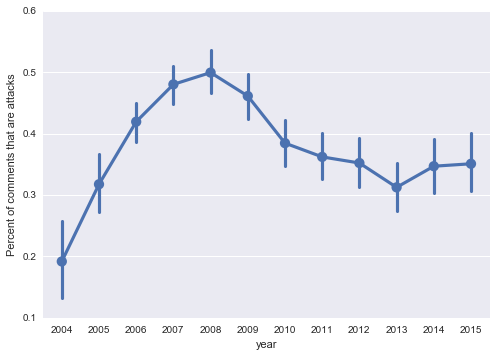

In [21]:
df_span = d['sample'].query('year > 2003 & year < 2016')
df_span['is_attack'] = (df_span['pred_recipient_score'] > 0.5).astype(int) * 100
x = 'year'
o = range(2004, 2016)
sns.pointplot(x=x, y = 'is_attack', data = df_span, order = o)
plt.ylabel('Percent of comments that are attacks')

The is a strong yearly pattern. The fraction of attacks peaked in 2008, which is when participation peaked as well, Since 2013, we have seen an increase in the fraction of attacks.

### Q: Is there a seasonal effect?

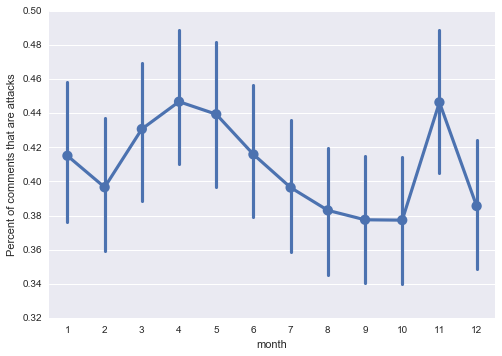

In [22]:
x = 'month'
o = range(1, 13)
sns.pointplot(x=x, y = 'is_attack', data = df_span, order = o)
plt.ylabel('Percent of comments that are attacks')

Not much of a pattern, large intervals relative to the trend.

### Q: Is there an hour of day effect?

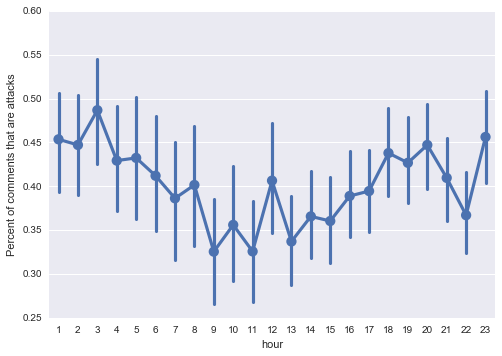

In [23]:
x = 'hour'
o  = range(1, 24)
sns.pointplot(x=x, y = 'is_attack', data = df_span, order = o)
plt.ylabel('Percent of comments that are attacks')

This is imperfect because timestamps are in UTC and not adjusted for time zone of the editor (the IPs are private). 